In [1]:
import skimage

In [2]:
import gc

import cv2
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pydicom
import tqdm
from pydicom.pixel_data_handlers.util import apply_voi_lut

from data import removeBackground, removePectoral
from data import (
    crop_medical_image,
    right_orient_mammogram,
    apply_canny,
    get_hough_lines,
    shortlist_lines,
    remove_pectoral_region,
    preprocess_images_task,
)

%matplotlib inline

In [65]:
# Import the training data
train_df = pd.read_csv('data/train.csv')
train_df.head()

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case
0,2,10006,462822612,L,CC,61.0,0,0,0,NaN,0,NaN,29,False
1,2,10006,1459541791,L,MLO,61.0,0,0,0,NaN,0,NaN,29,False
2,2,10006,1864590858,R,MLO,61.0,0,0,0,NaN,0,NaN,29,False
3,2,10006,1874946579,R,CC,61.0,0,0,0,NaN,0,NaN,29,False
4,2,10011,220375232,L,CC,55.0,0,0,0,0.0,0,NaN,21,True


In [60]:
file = '/home/rydevera3/data-science/kaggle/rsna-breast-cancer/data/train_images/10006/301168147.dcm'
dicom = pydicom.dcmread(file)

In [61]:
dicom

Dataset.file_meta -------------------------------
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Digital X-Ray Image Storage - For Presentation
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.840.10009.1.2.3.9228.1.301168147
(0002, 0010) Transfer Syntax UID                 UI: JPEG Lossless, Non-Hierarchical, First-Order Prediction (Process 14 [Selection Value 1])
(0002, 0012) Implementation Class UID            UI: 1.2.840.113654.2.3.1995.2.12.0
(0002, 0013) Implementation Version Name         SH: 'PYDICOM 2.3.0'
-------------------------------------------------
(0008, 0018) SOP Instance UID                    UI: 1.2.840.10009.1.2.3.9228.1.301168147
(0008, 0023) Content Date                        DA: '20221118'
(0008, 0033) Content Time                        TM: '185337.906078'
(0010, 0020) Patient ID                          LO: '9228'
(0018, 11a0) Body Part Thickness                 DS: '79.0'
(0018, 

In [62]:
dicom.pixel_array

array([[   0,    0,    0, ...,    0,    0,    0],
       [   0,    0,    0, ...,    0,    0,    0],
       [   0,    0,    0, ...,    0,    0,    0],
       ...,
       [3043, 3017, 3020, ...,    0,    0,    0],
       [3049, 3026, 3031, ...,    0,    0,    0],
       [3018, 3022, 3019, ...,    0,    0,    0]], dtype=uint16)

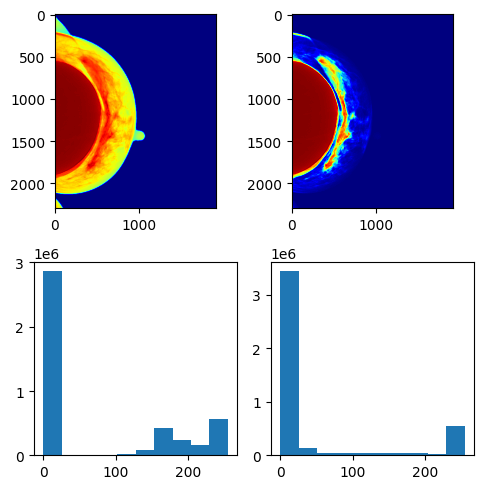

In [63]:
fig, axes = plt.subplots(2, 2, figsize=(5, 5))
axes = axes.flatten()

original_image = dicom.pixel_array
voi_lut_image = apply_voi_lut(dicom.pixel_array, dicom)

original_image = cv2.normalize(original_image, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_16UC1)
voi_lut_image = cv2.normalize(voi_lut_image, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_32F)

# # Scale images
# original_image = (
#     (original_image - original_image.min()) / (original_image.max() - original_image.min())
# )

if dicom.PhotometricInterpretation == 'MONOCHROME1':
    original_image = 255 - original_image
    voi_lut_image = 255 - voi_lut_image

# voi_lut_image = (
#     (voi_lut_image - voi_lut_image.min()) / (voi_lut_image.max() - voi_lut_image.min())
# )
# voi_lut_image = 1 - voi_lut_image

ax1 = axes[0]
ax1.imshow(original_image, cmap='jet')

ax2 = axes[1]
ax2.imshow(voi_lut_image, cmap='jet')

ax3 = axes[2]
ax3.hist(original_image.flatten())

ax4 = axes[3]
ax4.hist(voi_lut_image.flatten())

fig.tight_layout()

# Create the cleaned images

In [42]:
from data import removeBackground, removePectoral
from data import (
    # crop_medical_image,
    right_orient_mammogram,
    apply_canny,
    get_hough_lines,
    shortlist_lines,
    remove_pectoral_region
)

def crop_medical_image(image, output_size, threshold=20):
    """
    We will use components of opencv to remove excess space around
    medical images
    """
    # In some of our medical images there is a small frame at the outer
    # edge so we will do our best to generalize and remove this
    X = image.copy()
    X = X[5:-5, 5:-5]

    # Regions of non-empty pixels
    # Current experiemnts show that  is a good cutoff
    output = cv2.connectedComponentsWithStats(
        (X > threshold).astype(np.uint8), 8, cv2.CV_32F
    )

    # Get the stats
    stats = output[2]

    # Find the max area which always corresponds to the breast data
    index = stats[1:, 4].argmax() + 1
    x1, y1, w, h = stats[index][:4]
    x2 = x1 + w
    y2 = y1 + h

    # Cropped and cleaned image
    X_cleaned_image = X[y1:y2, x1:x2]
    X_cleaned_image = cv2.resize(X_cleaned_image, output_size)

    return X_cleaned_image

#Preprocess Image
#Recommended variable values
#ball_size = 5
#erosion_size = (4,2)
#erosion_iterations = 1
#dilation_size = (3,2)
#dilation_iterations = 6

image = crop_medical_image(voi_lut_image, output_size=(240, 384), threshold=20)
X = image.copy()

image_remove_background = removeBackground(
    X.astype(int),
    ball_size=5,
    erosion_size=(4, 2),
    erosion_iterations=1,
    dilation_size=(3, 2),
    dilation_iterations=6,
)
image_remove_background = right_orient_mammogram(image_remove_background.copy())

image_remove_pectoral = removePectoral(image_remove_background.copy())

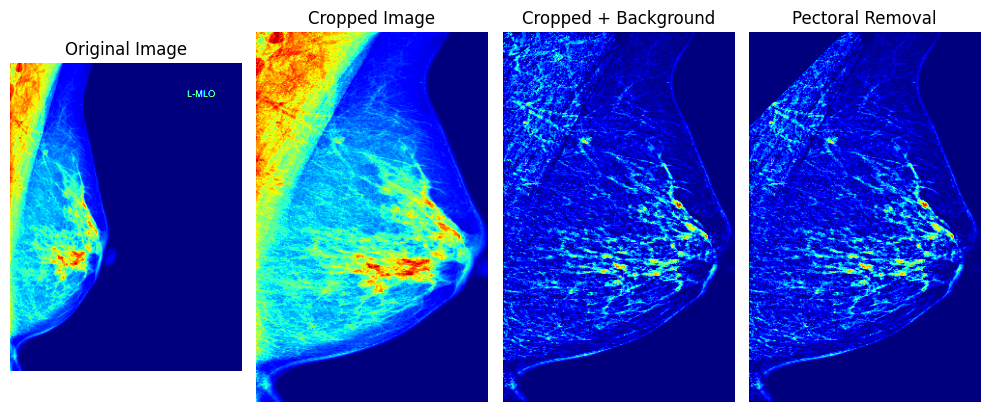

In [57]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(10, 7))

ax1.imshow(voi_lut_image, cmap='jet')
ax1.set_title('Original Image')
ax1.axis('off')

ax2.imshow(image, cmap='jet')
ax2.set_title('Cropped Image')
ax2.axis('off')

ax3.imshow(image_remove_background, cmap='jet')
ax3.set_title('Cropped + Background')
ax3.axis('off')

ax4.imshow(image_remove_pectoral, cmap='jet')
ax4.set_title('Pectoral Removal')
ax4.axis('off')

fig.tight_layout()
fig.savefig('./images/preprocessed_MLO_view.png', bbox_inches='tight', pad_inches=0.05)